In [1]:
import os 
import shutil
from ultralytics import YOLO
import torch
import supervision as sv
from tqdm import tqdm
from transformers import AutoProcessor, SiglipVisionModel
from more_itertools import chunked
import numpy as np


E0000 00:00:1765054085.177985   30424 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765054085.181604   30424 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765054085.191102   30424 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765054085.191124   30424 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765054085.191125   30424 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765054085.191126   30424 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
NOTEBOOKS_PATH = os.getcwd()
print(f"Notebook path: {NOTEBOOKS_PATH}")

PROJECT_PATH = os.path.dirname(NOTEBOOKS_PATH)
print(f"Project path: {PROJECT_PATH}")

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
print(f"Data Path: {DATA_PATH}")
print(f"Models Path: {MODELS_PATH}")

MODEL_PATH = os.path.join(MODELS_PATH, 'train5/weights/best.pt')
print(f"Model path: {MODEL_PATH}")

VIDEOS_PATH = os.path.join(DATA_PATH, 'videos')
print(f"Videos path: {VIDEOS_PATH}")

Notebook path: /home/gomaa/Ai/projects/Football-Match-Analysis/notebooks
Project path: /home/gomaa/Ai/projects/Football-Match-Analysis
Data Path: /home/gomaa/Ai/projects/Football-Match-Analysis/data
Models Path: /home/gomaa/Ai/projects/Football-Match-Analysis/models
Model path: /home/gomaa/Ai/projects/Football-Match-Analysis/models/train5/weights/best.pt
Videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU count: 1
Device: NVIDIA GeForce RTX 2050


# Create Embeddings

## Load Model

In [4]:
model = YOLO(MODEL_PATH)

## Videos Paths

In [5]:
VIDEO_NAME = 'vid1.mp4' 
SOURCE_VIDEO_PATH = os.path.join(VIDEOS_PATH, VIDEO_NAME)
print(f"Source Video: {SOURCE_VIDEO_PATH}")

Source Video: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos/vid1.mp4


### Take Crops

In [6]:
def get_crops(src_vid, stride=30, id=2):
    frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, stride=stride)

    crops_list = []

    for frame in frame_generator:

        cp_frame = frame.copy()

        result = model.predict(cp_frame, conf=0.3)[0]
        
        detections = sv.Detections.from_ultralytics(result)

        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        detections = detections[detections.class_id == id]

        crops_list += [
            sv.crop_image(cp_frame, xyxy)
            for xyxy in detections.xyxy
        ]

    return crops_list


In [14]:
STRIDE = 30
PLAYER_ID = 2

crops = get_crops(SOURCE_VIDEO_PATH, STRIDE, PLAYER_ID)


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 79.2ms
Speed: 12.2ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.9ms
Speed: 4.1ms preprocess, 76.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 74.0ms
Speed: 4.2ms preprocess, 74.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 74.0ms
Speed: 2.9ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 74.0ms
Speed: 3.7ms preprocess, 74.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 74.1ms
Speed: 4.0ms preprocess, 74.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 74.0ms
Speed: 3.8ms preprocess, 74.0ms inference, 0.9ms postprocess per i

In [9]:
print(f"Number of Crops = {len(crops)}")

Number of Crops = 516


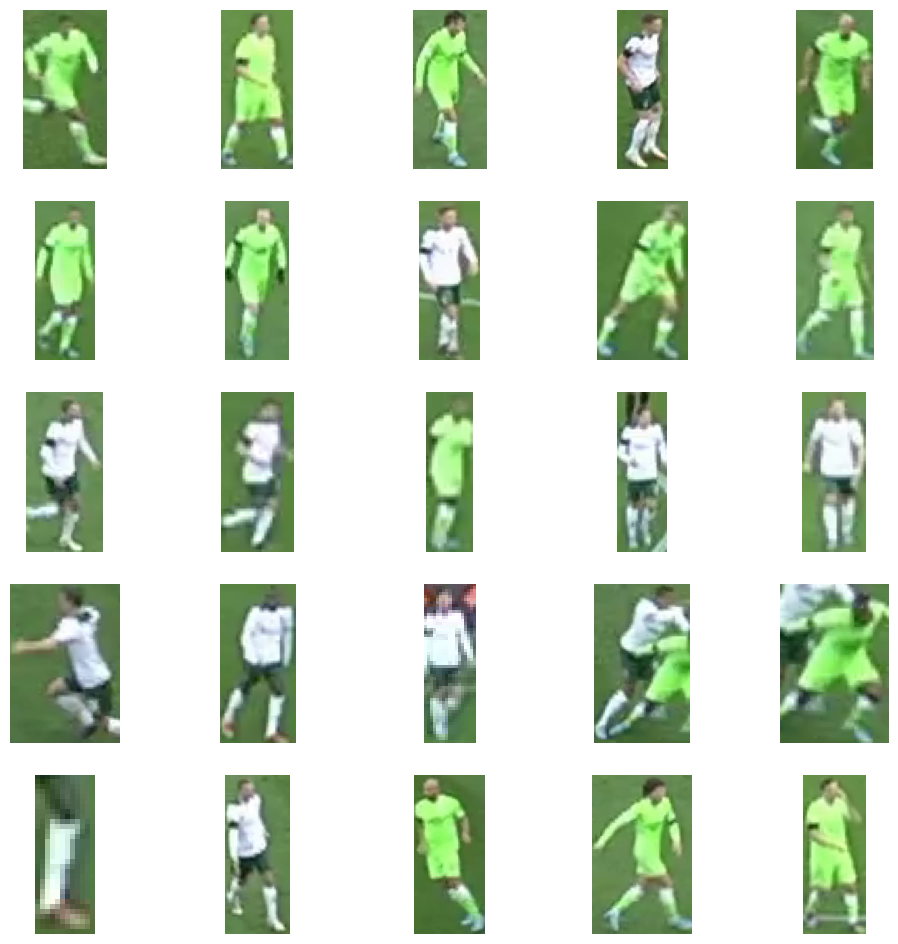

In [10]:
sv.plot_images_grid(crops[:25], grid_size=(5,5))

In [7]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

embeddings_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
embeddings_processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
BATCH_SIZE = 32
STRIDE = 30
PLAYER_ID = 2

crops = get_crops(SOURCE_VIDEO_PATH, STRIDE, PLAYER_ID)

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)

data = []

with torch.no_grad():
    for batch in batches:
        inputs = embeddings_processor(images=batch, return_tensors='pt').to(DEVICE)
        outputs = embeddings_model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
print(data.shape)



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 83.6ms
Speed: 2.6ms preprocess, 83.6ms inference, 8.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 73.9ms
Speed: 4.6ms preprocess, 73.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 74.0ms
Speed: 3.9ms preprocess, 74.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 74.2ms
Speed: 5.4ms preprocess, 74.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 74.1ms
Speed: 5.3ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 74.1ms
Speed: 4.1ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 74.0ms
Speed: 4.2ms preprocess, 74.0ms inference, 1.0ms postprocess per im

In [22]:
import umap
from sklearn.cluster import KMeans

In [26]:
class TeamClassifier():
    def __init__(self, device):
        self.device = device
        self.SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'
        self.dim_reducer = umap.UMAP(n_components=3)
        self.clustering_model = KMeans(n_clusters=2)

    def create_embeddings(self, crops):
        embeddings_model = SiglipVisionModel.from_pretrained(self.SIGLIP_MODEL_PATH).to(self.device)
        embeddings_processor = AutoProcessor.from_pretrained(self.SIGLIP_MODEL_PATH)

        crops = [sv.cv2_to_pillow(crop) for crop in crops]
        batches = chunked(crops, BATCH_SIZE)

        data = []

        with torch.no_grad():
            for batch in batches:
                inputs = embeddings_processor(images=batch, return_tensors='pt').to(self.device)
                outputs = embeddings_model(**inputs)
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)

        data = np.concatenate(data)
        
        
        return data

    def fit(self, crops):
        embeddings = self.create_embeddings(crops)
        projections = self.dim_reducer.fit_transform(embeddings)
        self.clusters = self.clustering_model.fit_predict(projections)
        return self.clusters
    
    def predict(self, crops):
        embeddings = self.create_embeddings(crops)
        projections = self.dim_reducer.transform(embeddings)
        clusters = self.clustering_model.predict(projections)

        return clusters



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 79.1ms
Speed: 13.3ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 78.9ms
Speed: 4.3ms preprocess, 78.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 79.1ms
Speed: 3.4ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 74.0ms
Speed: 3.4ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 74.1ms
Speed: 4.0ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 74.0ms
Speed: 3.2ms preprocess, 74.0ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 74.1ms
Speed: 3.0ms preprocess, 74.1ms inference, 0.9ms postprocess per i

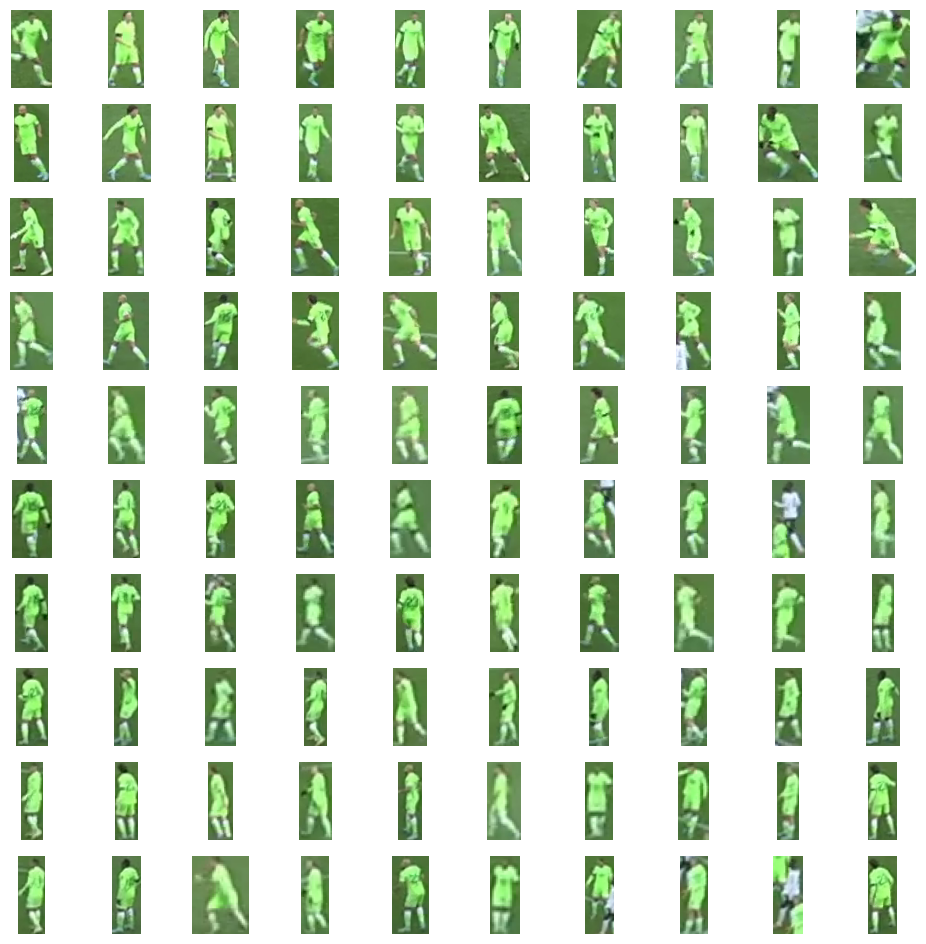

In [27]:
team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)
preds = team_classifier.predict(crops)
team_1 = [
    crop
    for crop, cluster in zip(crops, preds)
    if cluster == 0
]

team_2 = [
    crop
    for crop, cluster in zip(crops, preds)
    if cluster == 1
]

sv.plot_images_grid(team_1[:100], grid_size=(10,10))

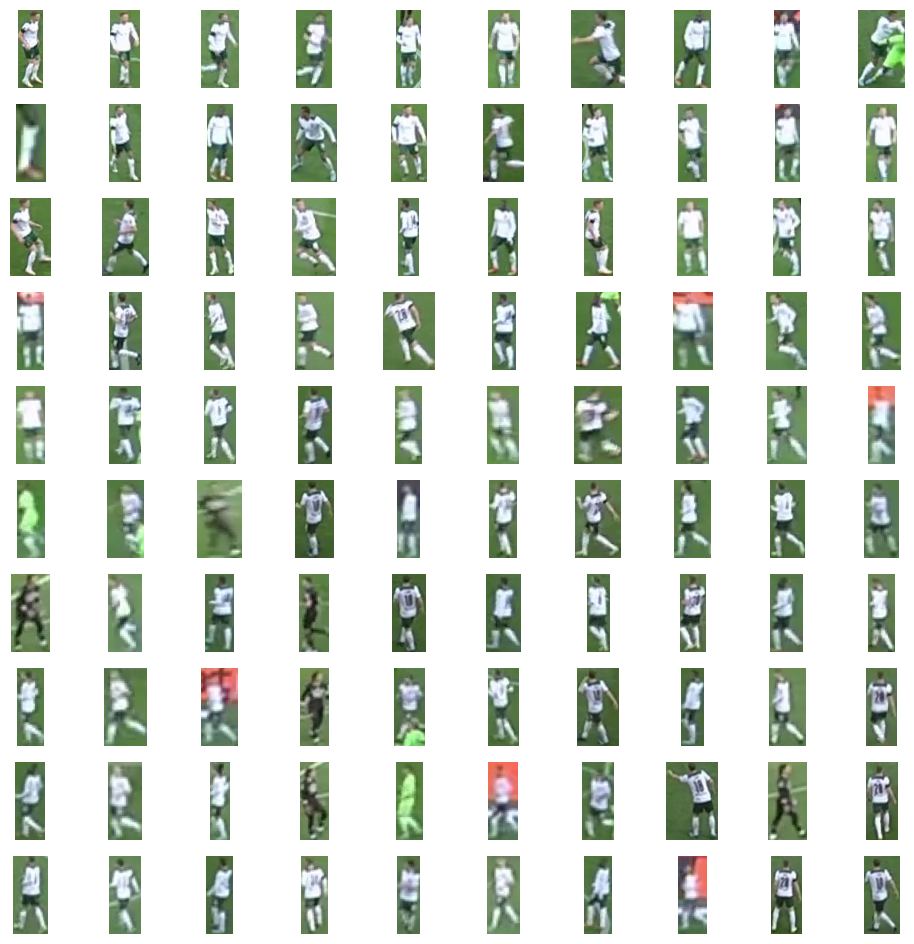

In [28]:
sv.plot_images_grid(team_2[:100], grid_size=(10,10))


In [11]:
dim_reducer = umap.UMAP(n_components=3)
clustering_model = KMeans(n_clusters=2)

In [12]:
embeddings = data.copy()
projections = dim_reducer.fit_transform(embeddings)

print(f"Shape of Embeddings = {embeddings.shape}")
print(f"Shape of Embeddings Projections = {projections.shape}")

Shape of Embeddings = (516, 768)
Shape of Embeddings Projections = (516, 3)


In [13]:
clusters = clustering_model.fit_predict(projections)

In [14]:
print(clusters[:10])

[1 1 1 0 1 1 1 0 1 1]


In [15]:
team_1 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 0
]

team_2 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 1
]

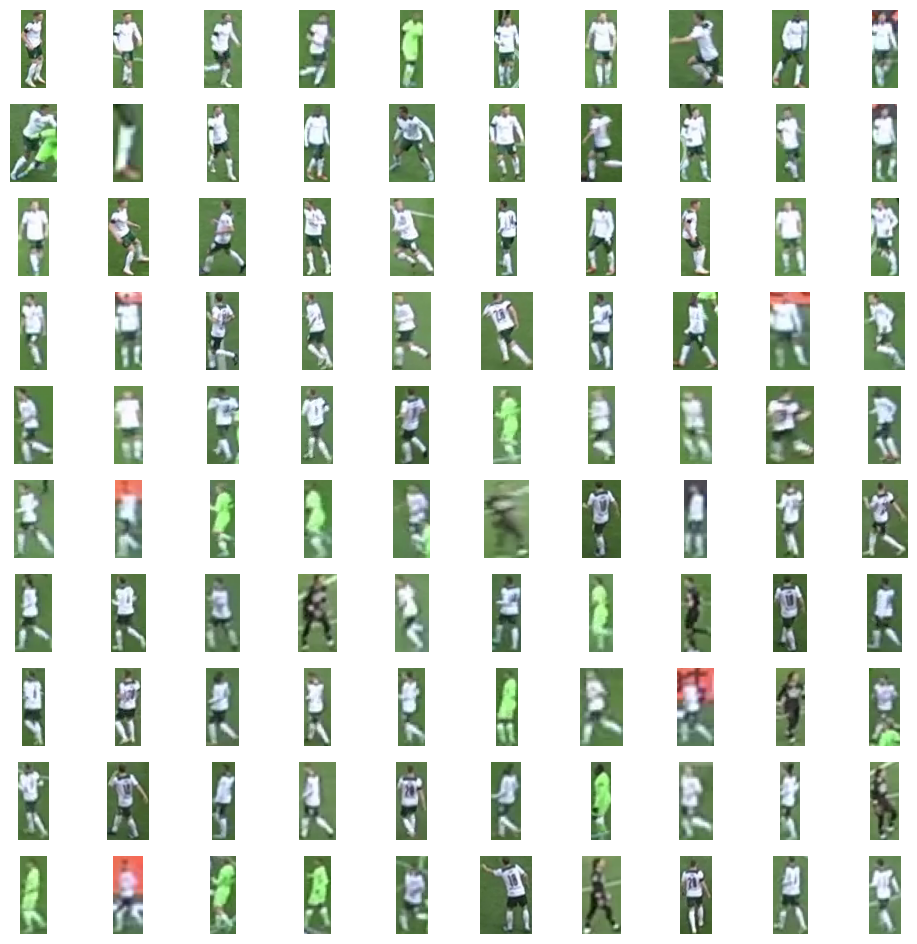

In [18]:
sv.plot_images_grid(team_1[:100], grid_size=(10,10))

In [19]:
RESULT_VIDEO_PATH = os.path.join(DATA_PATH, 'results-videos')
print(f"Result videos path: {RESULT_VIDEO_PATH}")

Result videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/results-videos



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 79.1ms
Speed: 13.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 79.1ms
Speed: 3.9ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 74.2ms
Speed: 3.0ms preprocess, 74.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 74.1ms
Speed: 3.3ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 74.1ms
Speed: 3.7ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 74.2ms
Speed: 4.0ms preprocess, 74.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 74.2ms
Speed: 4.0ms preprocess, 74.2ms inference, 0.9ms postprocess per i

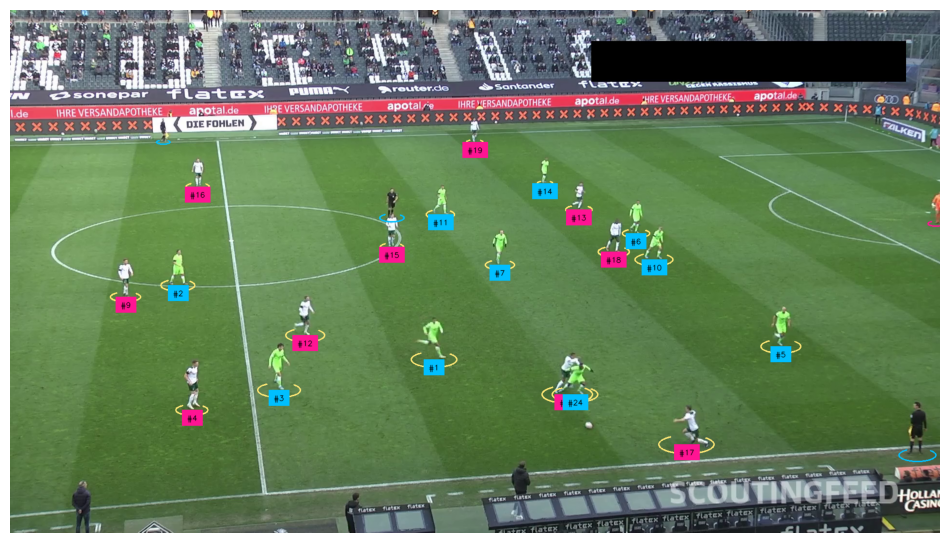

In [29]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack1.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0

ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)


team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)


result = model.predict(frame, conf=0.25)[0]

detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

other_detections = detections[detections.class_id!=BALL_ID]
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
other_detections = tracker.update_with_detections(other_detections)


players_detections = other_detections[other_detections.class_id==PLAYER_ID]
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)



labels = [
    f"#{tracker_id}"
    for tracker_id in players_detections.tracker_id
]



annotated_frame = frame.copy()
annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=players_detections, labels=labels)
sv.plot_image(annotated_frame)
